## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

1.  [Recap](#0)<br>
2.  [Data Modeling](#2)<br>
3.  [Model Evaluation](#4)<br>
    </div>
    <hr>


# Recap <a id="0"></a>

In Lab **From Understanding to Preparation**, we explored the data and prepared it for modeling.


The data was compiled by a researcher named Yong-Yeol Ahn, who scraped tens of thousands of food recipes (cuisines and ingredients) from three different websites, namely:


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0103EN-SkillsNetwork/labs/Module%202/images/lab2_fig3_allrecipes.png" width=500>
<div align="center">
www.allrecipes.com
</div>
<br/><br/>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0103EN-SkillsNetwork/labs/Module%202/images/lab2_fig4_epicurious.png" width=500>
<div align="center">
www.epicurious.com
</div>
<br/><br/>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0103EN-SkillsNetwork/labs/Module%202/images/lab2_fig5_menupan.png" width=500>
<div align="center">
www.menupan.com
</div>
<br/><br/>


In [1]:
import pandas as pd # import library to read data into dataframe
pd.set_option("display.max_columns", None)
import numpy as np # import numpy library
import re # import library for regular expression
import random # library for random number generation

We already placed the data on an IBM server for your convenience, so let's download it from server and read it into a dataframe called **recipes**.


In [2]:
recipes = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0103EN-SkillsNetwork/labs/Module%202/recipes.csv")

print("Data read into dataframe!") # takes about 30 seconds

Data read into dataframe!


We will repeat the preprocessing steps that we implemented in Lab **From Understanding to Preparation** in order to prepare the data for modeling. For more details on preparing the data, please refer to Lab **From Understanding to Preparation**.


In [3]:
# fix name of the column displaying the cuisine
column_names = recipes.columns.values
column_names[0] = "cuisine"
recipes.columns = column_names

# convert cuisine names to lower case
recipes["cuisine"] = recipes["cuisine"].str.lower()

# make the cuisine names consistent
recipes.loc[recipes["cuisine"] == "austria", "cuisine"] = "austrian"
recipes.loc[recipes["cuisine"] == "belgium", "cuisine"] = "belgian"
recipes.loc[recipes["cuisine"] == "china", "cuisine"] = "chinese"
recipes.loc[recipes["cuisine"] == "canada", "cuisine"] = "canadian"
recipes.loc[recipes["cuisine"] == "netherlands", "cuisine"] = "dutch"
recipes.loc[recipes["cuisine"] == "france", "cuisine"] = "french"
recipes.loc[recipes["cuisine"] == "germany", "cuisine"] = "german"
recipes.loc[recipes["cuisine"] == "india", "cuisine"] = "indian"
recipes.loc[recipes["cuisine"] == "indonesia", "cuisine"] = "indonesian"
recipes.loc[recipes["cuisine"] == "iran", "cuisine"] = "iranian"
recipes.loc[recipes["cuisine"] == "italy", "cuisine"] = "italian"
recipes.loc[recipes["cuisine"] == "japan", "cuisine"] = "japanese"
recipes.loc[recipes["cuisine"] == "israel", "cuisine"] = "jewish"
recipes.loc[recipes["cuisine"] == "korea", "cuisine"] = "korean"
recipes.loc[recipes["cuisine"] == "lebanon", "cuisine"] = "lebanese"
recipes.loc[recipes["cuisine"] == "malaysia", "cuisine"] = "malaysian"
recipes.loc[recipes["cuisine"] == "mexico", "cuisine"] = "mexican"
recipes.loc[recipes["cuisine"] == "pakistan", "cuisine"] = "pakistani"
recipes.loc[recipes["cuisine"] == "philippines", "cuisine"] = "philippine"
recipes.loc[recipes["cuisine"] == "scandinavia", "cuisine"] = "scandinavian"
recipes.loc[recipes["cuisine"] == "spain", "cuisine"] = "spanish_portuguese"
recipes.loc[recipes["cuisine"] == "portugal", "cuisine"] = "spanish_portuguese"
recipes.loc[recipes["cuisine"] == "switzerland", "cuisine"] = "swiss"
recipes.loc[recipes["cuisine"] == "thailand", "cuisine"] = "thai"
recipes.loc[recipes["cuisine"] == "turkey", "cuisine"] = "turkish"
recipes.loc[recipes["cuisine"] == "vietnam", "cuisine"] = "vietnamese"
recipes.loc[recipes["cuisine"] == "uk-and-ireland", "cuisine"] = "uk-and-irish"
recipes.loc[recipes["cuisine"] == "irish", "cuisine"] = "uk-and-irish"


# remove data for cuisines with < 50 recipes:
recipes_counts = recipes["cuisine"].value_counts()
cuisines_indices = recipes_counts > 50

cuisines_to_keep = list(np.array(recipes_counts.index.values)[np.array(cuisines_indices)])
recipes = recipes.loc[recipes["cuisine"].isin(cuisines_to_keep)]

# convert all Yes's to 1's and the No's to 0's
recipes = recipes.replace(to_replace="Yes", value=1)
recipes = recipes.replace(to_replace="No", value=0)

<hr>


# Data Modeling <a id="2"></a>


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0103EN-SkillsNetwork/labs/Module%204/images/flowchart_data_modeling.png" width=500>


Download and install more libraries and dependencies to build decision trees.


In [4]:
# import decision trees scikit-learn libraries
%matplotlib inline
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt

!conda install python-graphviz --yes
import graphviz

from sklearn.tree import export_graphviz

import itertools

/bin/bash: conda: command not found


Check the data again!


In [5]:
recipes.head()

,cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,artichoke,asparagus,avocado,bacon,baked_potato,balm,banana,barley,bartlett_pear,basil,bay,bean,beech,beef,beef_broth,beef_liver,beer,beet,bell_pepper,bergamot,berry,bitter_orange,black_bean,black_currant,black_mustard_seed_oil,black_pepper,black_raspberry,black_sesame_seed,black_tea,blackberry,blackberry_brandy,blue_cheese,blueberry,bone_oil,bourbon_whiskey,brandy,brassica,bread,broccoli,brown_rice,brussels_sprout,buckwheat,butter,buttermilk,cabbage,cabernet_sauvignon_wine,cacao,camembert_cheese,cane_molasses,caraway,cardamom,carnation,carob,carrot,cashew,cassava,catfish,cauliflower,caviar,cayenne,celery,celery_oil,cereal,chamomile,champagne_wine,chayote,cheddar_cheese,cheese,cherry,cherry_brandy,chervil,chicken,chicken_broth,chicken_liver,chickpea,chicory,chinese_cabbage,chive,cider,cilantro,cinnamon,citrus,citrus_peel,clam,clove,cocoa,coconut,coconut_oil,cod,coffee,cognac,concord_grape,condiment,coriander,corn,corn_flake,corn_grit,cottage_cheese,crab,cranberry,cream,cream_cheese,cucumber,cumin,cured_pork,currant,date,dill,durian,eel,egg,egg_noodle,elderberry,emmental_cheese,endive,enokidake,fennel,fenugreek,feta_cheese,fig,fish,flower,frankfurter,fruit,galanga,gardenia,garlic,gelatin,geranium,gin,ginger,goat_cheese,grape,grape_brandy,grape_juice,grapefruit,green_bell_pepper,green_tea,gruyere_cheese,guava,haddock,ham,hazelnut,herring,holy_basil,honey,hop,horseradish,huckleberry,jamaican_rum,japanese_plum,jasmine,jasmine_tea,juniper_berry,kaffir_lime,kale,katsuobushi,kelp,kidney_bean,kiwi,kohlrabi,kumquat,lamb,lard,laurel,lavender,leaf,leek,lemon,lemon_juice,lemon_peel,lemongrass,lentil,lettuce,licorice,lilac_flower_oil,lima_bean,lime,lime_juice,lime_peel_oil,lingonberry,litchi,liver,lobster,long_pepper,lovage,macadamia_nut,macaroni,mace,mackerel,malt,mandarin,mandarin_peel,mango,maple_syrup,marjoram,mate,matsutake,meat,melon,milk,milk_fat,mint,mozzarella_cheese,mung_bean,munster_cheese,muscat_grape,mushroom,mussel,mustard,mutton,nectarine,nira,nut,nutmeg,oat,oatmeal,octopus,okra,olive,olive_oil,onion,orange,orange_flower,orange_juice,orange_peel,oregano,ouzo,oyster,palm,papaya,parmesan_cheese,parsley,parsnip,passion_fruit,pea,peach,peanut,peanut_butter,peanut_oil,pear,pear_brandy,pecan,pelargonium,pepper,peppermint,peppermint_oil,pimenta,pimento,pineapple,pistachio,plum,popcorn,porcini,pork,pork_liver,pork_sausage,port_wine,potato,potato_chip,prawn,prickly_pear,provolone_cheese,pumpkin,quince,radish,raisin,rapeseed,raspberry,raw_beef,red_algae,red_bean,red_kidney_bean,red_wine,rhubarb,rice,roasted_almond,roasted_beef,roasted_hazelnut,roasted_meat,roasted_nut,roasted_peanut,roasted_pecan,roasted_pork,roasted_sesame_seed,romano_cheese,root,roquefort_cheese,rose,rosemary,rum,rutabaga,rye_bread,rye_flour,saffron,sage,sake,salmon,salmon_roe,sassafras,sauerkraut,savory,scallion,scallop,sea_algae,seaweed,seed,sesame_oil,sesame_seed,shallot,sheep_cheese,shellfish,sherry,shiitake,shrimp,smoke,smoked_fish,smoked_salmon,smoked_sausage,sour_cherry,sour_milk,soy_sauce,soybean,soybean_oil,spearmint,squash,squid,star_anise,starch,strawberry,strawberry_jam,strawberry_juice,sturgeon_caviar,sumac,sunflower_oil,sweet_potato,swiss_cheese,tabasco_pepper,tamarind,tangerine,tarragon,tea,tequila,thai_pepper,thyme,tomato,tomato_juice,truffle,tuna,turkey,turmeric,turnip,vanilla,veal,vegetable,vegetable_oil,vinegar,violet,walnut,wasabi,watercress,watermelon,wheat,wheat_bread,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
0,vietnamese,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,

## [bamboo_tree] Only Asian and Indian Cuisines

Here, we are creating a decision tree for the recipes for just some of the Asian (Korean, Japanese, Chinese, Thai) and Indian cuisines. The reason for this is because the decision tree does not run well when the data is biased towards one cuisine, in this case American cuisines. One option is to exclude the American cuisines from our analysis or just build decision trees for different subsets of the data. Let's go with the latter solution.


Let's build our decision tree using the data pertaining to the Asian and Indian cuisines and name our decision tree _bamboo_tree_.


In [6]:
# select subset of cuisines
asian_indian_recipes = recipes[recipes.cuisine.isin(["korean", "japanese", "chinese", "thai", "indian"])]
cuisines = asian_indian_recipes["cuisine"]
ingredients = asian_indian_recipes.iloc[:,1:]

bamboo_tree = tree.DecisionTreeClassifier(max_depth=3)
bamboo_tree.fit(ingredients, cuisines)

print("Decision tree model saved to bamboo_tree!")

Decision tree model saved to bamboo_tree!


Let's plot the decision tree and examine how it looks like.


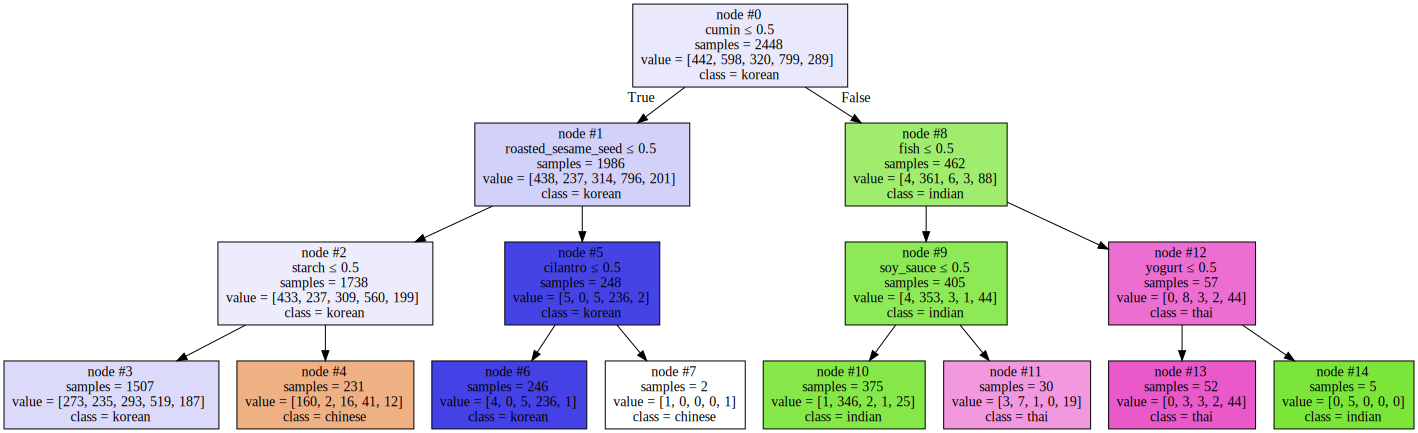

In [7]:
export_graphviz(bamboo_tree,
                feature_names=list(ingredients.columns.values),
                out_file="bamboo_tree.dot",
                class_names=np.unique(cuisines),
                filled=True,
                node_ids=True,
                special_characters=True,
                impurity=False,
                label="all",
                leaves_parallel=False)

with open("bamboo_tree.dot") as bamboo_tree_image:
    bamboo_tree_graph = bamboo_tree_image.read()
graphviz.Source(bamboo_tree_graph)

The decision tree learned:

-   If a recipe contains _cumin_ and _fish_ and **no** _yoghurt_, then it is most likely a **Thai** recipe.
-   If a recipe contains _cumin_ but **no** _fish_ and **no** _soy_sauce_, then it is most likely an **Indian** recipe.


You can analyze the remaining branches of the tree to come up with similar rules for determining the cuisine of different recipes. 


Feel free to select another subset of cuisines and build a decision tree of their recipes. You can select some European cuisines and build a decision tree to explore the ingredients that differentiate them.


# Model Evaluation <a id="4"></a>


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0103EN-SkillsNetwork/labs/Module%204/images/flowchart_evaluation.png" width=500>


To evaluate our model of Asian and Indian cuisines, we will split our dataset into a training set and a test set. We will build the decision tree using the training set. Then, we will test the model on the test set and compare the cuisines that the model predicts to the actual cuisines. 


Let's first create a new dataframe using only the data pertaining to the Asian and the Indian cuisines, and let's call the new dataframe **bamboo**.


In [8]:
bamboo = recipes[recipes.cuisine.isin(["korean", "japanese", "chinese", "thai", "indian"])]

Let's see how many recipes exist for each cuisine.


In [9]:
bamboo["cuisine"].value_counts()

korean      799
indian      598
chinese     442
japanese    320
thai        289
Name: cuisine, dtype: int64

Let's remove 30 recipes from each cuisine to use as the test set, and let's name this test set **bamboo_test**.


In [10]:
# set sample size
sample_n = 30

Create a dataframe containing 30 recipes from each cuisine, selected randomly.


In [11]:
# take 30 recipes from each cuisine
random.seed(1234) # set random seed
bamboo_test = bamboo.groupby("cuisine", group_keys=False).apply(lambda x: x.sample(sample_n))

bamboo_test_ingredients = bamboo_test.iloc[:,1:] # ingredients
bamboo_test_cuisines = bamboo_test["cuisine"] # corresponding cuisines or labels

Check that there are 30 recipes for each cuisine.


In [12]:
# check that we have 30 recipes from each cuisine
bamboo_test["cuisine"].value_counts()

thai        30
japanese    30
indian      30
korean      30
chinese     30
Name: cuisine, dtype: int64

Next, let's create the training set by removing the test set from the **bamboo** dataset, and let's call the training set **bamboo_train**.


In [13]:
bamboo_test_index = bamboo.index.isin(bamboo_test.index)
bamboo_train = bamboo[~bamboo_test_index]

bamboo_train_ingredients = bamboo_train.iloc[:,1:] # ingredients
bamboo_train_cuisines = bamboo_train["cuisine"] # corresponding cuisines or labels

Check that there are 30 _fewer_ recipes now for each cuisine.


In [14]:
bamboo_train["cuisine"].value_counts()

korean      769
indian      568
chinese     412
japanese    290
thai        259
Name: cuisine, dtype: int64

Let's build the decision tree using the training set, **bamboo_train**, and name the generated tree **bamboo_train_tree** for prediction.


In [15]:
bamboo_train_tree = tree.DecisionTreeClassifier(max_depth=15)
bamboo_train_tree.fit(bamboo_train_ingredients, bamboo_train_cuisines)

print("Decision tree model saved to bamboo_train_tree!")

Decision tree model saved to bamboo_train_tree!


Let's plot the decision tree and explore it.


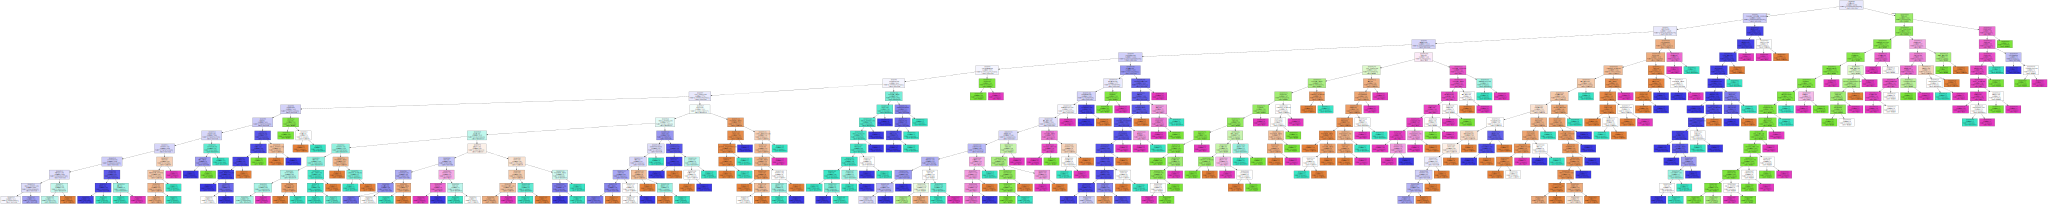

In [16]:
export_graphviz(bamboo_train_tree,
                feature_names=list(bamboo_train_ingredients.columns.values),
                out_file="bamboo_train_tree.dot",
                class_names=np.unique(bamboo_train_cuisines),
                filled=True,
                node_ids=True,
                special_characters=True,
                impurity=False,
                label="all",
                leaves_parallel=False)

with open("bamboo_train_tree.dot") as bamboo_train_tree_image:
    bamboo_train_tree_graph = bamboo_train_tree_image.read()
graphviz.Source(bamboo_train_tree_graph)

Now that we defined our tree to be deeper, more decision nodes are generated.


#### Now let's test our model on the test data.


In [17]:
bamboo_pred_cuisines = bamboo_train_tree.predict(bamboo_test_ingredients)

To quantify how well the decision tree is able to determine the cuisine of each recipe correctly, we will create a confusion matrix which presents a nice summary on how many recipes from each cuisine are correctly classified. It also sheds some light on what cuisines are being confused with what other cuisines.


So let's go ahead and create the confusion matrix for how well the decision tree is able to correctly classify the recipes in **bamboo_test**.


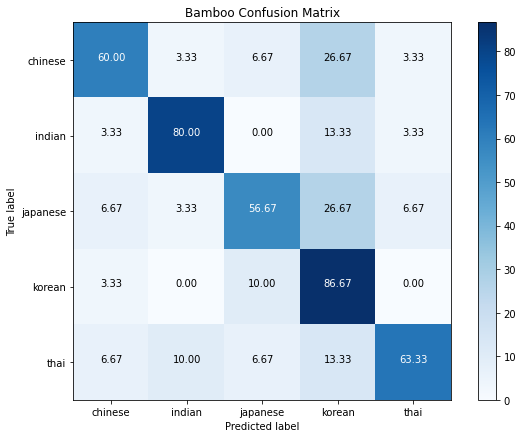

In [18]:
test_cuisines = np.unique(bamboo_test_cuisines)
bamboo_confusion_matrix = confusion_matrix(bamboo_test_cuisines, bamboo_pred_cuisines, test_cuisines)
title = 'Bamboo Confusion Matrix'
cmap = plt.cm.Blues

plt.figure(figsize=(8, 6))
bamboo_confusion_matrix = (
    bamboo_confusion_matrix.astype('float') / bamboo_confusion_matrix.sum(axis=1)[:, np.newaxis]
    ) * 100

plt.imshow(bamboo_confusion_matrix, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(test_cuisines))
plt.xticks(tick_marks, test_cuisines)
plt.yticks(tick_marks, test_cuisines)

fmt = '.2f'
thresh = bamboo_confusion_matrix.max() / 2.
for i, j in itertools.product(range(bamboo_confusion_matrix.shape[0]), range(bamboo_confusion_matrix.shape[1])):
    plt.text(j, i, format(bamboo_confusion_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if bamboo_confusion_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

After running the above code, you should get a confusion matrix similar to the following:


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0103EN-SkillsNetwork/labs/Module%204/images/lab4_fig6_confusion_matrix.png" width=500>


The rows represent the actual cuisines from the dataset and the columns represent the predicted ones. Each row should sum to 100%. According to this confusion matrix, we make the following observations:

-   Using the first row in the confusion matrix, 60% of the **Chinese** recipes in **bamboo_test** were correctly classified by our decision tree whereas 37% of the **Chinese** recipes were misclassified as **Korean** and 3% were misclassified as **Indian**.

-   Using the Indian row, 77% of the **Indian** recipes in **bamboo_test** were correctly classified by our decision tree and 3% of the **Indian** recipes were misclassified as **Chinese** and 13% were misclassified as **Korean** and 7% were misclassified as **Thai**.


**Please note** that because decision trees are created using random sampling of the datapoints in the training set, then you may not get the same results every time you create the decision tree even using the same training set. The performance should still be comparable though! So don't worry if you get slightly different numbers in your confusion matrix than the ones shown above.


Using the reference confusion matrix, how many **Japanese** recipes were correctly classified by our decision tree?




```python
    #The correct answer is:
    36.67%.
```

</details>


Also using the reference confusion matrix, how many **Korean** recipes were misclassified as **Japanese**?




```python
    #The correct answer is:
     3.33%.
```




What cuisine has the least number of recipes correctly classified by the decision tree using the reference confusion matrix?




```python
    #The correct answer is:
     Japanese cuisine, with 36.67% only.
```

</details>


<br>
<hr>
